<a href="https://colab.research.google.com/github/hkvision/BigDL/blob/update-colab/python/orca/colab-notebook/quickstart/ncf_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


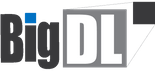
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install BigDL Orca**

You can install the latest pre-release version with spark3 using `pip install --pre --upgrade bigdl-orca-spark3[ray]`. 

In [2]:
# Installing bigdl from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca-spark3[ray]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.8 MB 1.9 MB/s 
     |████████████████████████████████| 71.0 MB 354 bytes/s 
     |████████████████████████████████| 35.4 MB 440 kB/s 
     |████████████████████████████████| 48.5 MB 65 kB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 85 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 32.7 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 32.4 MB/s 
     |████████████████████████████████| 144 kB 30.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 51.0 MB 41 kB/s 
     |████████████████████████████████| 212.4 MB 69 kB/s 
     |████████████████████████████████| 198 kB 46.0 MB/s 
     |████████████████████████████████| 246 kB 61.4 MB/s 
     |██████████████████████████████

## **Using Spark Dataframes for Distribtued Deep Learning** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [3]:
import os
import zipfile
import argparse

import numpy as np

from bigdl.dllib.feature.dataset import base

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.orca.learn.tf2 import Estimator

## **Init Orca Context** 

In [4]:
# recommended to set it to True when running BigDL in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=1) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_3.1.2-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [5]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

5840896/5917549 [============================>.] - ETA: 0sSuccessfully downloaded ml-1m.zip 5917549 bytes.


In [6]:
# read csv
rating_files="./ml-1m/ratings.dat"
spark = OrcaContext.get_spark_session()
df = spark.read.csv(rating_files, sep='::', header=True, inferSchema=True).toDF("user", "item", "label", "timestamp")

df.show(5)

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

+----+----+-----+---------+
|user|item|label|timestamp|
+----+----+-----+---------+
|   1| 661|    3|978302109|
|   1| 914|    3|978301968|
|   1|3408|    4|978300275|
|   1|2355|    5|978824291|
|   1|1197|    3|978302268|
+----+----+-----+---------+
only showing top 5 rows

1 6040 1 3952


In [7]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [8]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], 100)

### **Define NCF Model**

In [9]:
def model_creator(config):
    import tensorflow as tf
    from tensorflow import keras
    embedding_size=16
    user = keras.layers.Input(dtype=tf.int32, shape=(None,))
    item = keras.layers.Input(dtype=tf.int32, shape=(None,))
    label = keras.layers.Input(dtype=tf.int32, shape=(None,))

    with tf.name_scope("GMF"):
        user_embed_GMF = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_GMF = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        GMF = keras.layers.Multiply()([user_embed_GMF, item_embed_GMF])

    with tf.name_scope("MLP"):
        user_embed_MLP = keras.layers.Embedding(max_user_id + 1, embedding_size)(user)
        item_embed_MLP = keras.layers.Embedding(max_item_id + 1, embedding_size)(item)
        interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
        layer1_MLP = keras.layers.Dense(units=embedding_size * 2, activation='relu')(interaction)
        layer1_MLP = keras.layers.Dropout(rate=0.2)(layer1_MLP)
        layer2_MLP = keras.layers.Dense(units=embedding_size, activation='relu')(layer1_MLP)
        layer2_MLP = keras.layers.Dropout(rate=0.2)(layer2_MLP)
        layer3_MLP = keras.layers.Dense(units=embedding_size // 2, activation='relu')(layer2_MLP)
        layer3_MLP = keras.layers.Dropout(rate=0.2)(layer3_MLP)

    # Concate the two parts together
    with tf.name_scope("concatenation"):
        concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
        outputs = keras.layers.Dense(units=5, activation='softmax')(concatenation)
    
    model = keras.Model(inputs=[user, item], outputs=outputs)
    model.compile(optimizer= "adam",
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    return model

### **Fit with Orca Estimator**

In [10]:
batch_size=1280
epochs=2
model_dir='./'

# create an Estimator
est = Estimator.from_keras(model_creator=model_creator, workers_per_node=1)

stats = est.fit(train_data,
                epochs=epochs,
                batch_size=batch_size,
                feature_cols=['user', 'item'],
                label_cols=['label'],
                steps_per_epoch=800000 // batch_size,
                validation_data=test_data,
                validation_steps = 200000 // batch_size)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
est.save(checkpoint_path)

{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-07-25_14-20-49_649104_58/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-25_14-20-49_649104_58/sockets/raylet', 'webui_url': None, 'session_dir': '/tmp/ray/session_2022-07-25_14-20-49_649104_58', 'metrics_export_port': 62123, 'node_id': 'c1d5c21b793dd02bcd3fb6aecb8d969943fe1fa9148a6e78b83feea3'}


(Worker pid=526) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/bigdl/orca/learn/tf2/tf_runner.py:317: _CollectiveAllReduceStrategyExperimental.__init__ (from tensorflow.python.distribute.collective_all_reduce_strategy) is deprecated and will be removed in a future version.
(Worker pid=526) Instructions for updating:
(Worker pid=526) use distribute.MultiWorkerMirroredStrategy instead
(Worker pid=526) 2022-07-25 14:21:00.811115: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-25 14:22:14,966	WARNING worker.py:1245 -- (ip=172.28.0.2) The agent on node df74814a9ab3 failed to be restarted 5 times. There are 3 possible problems if you see this error.
  1. The dashboard might not display correct information on this node.
  2. Metrics on this node won't be reported.
  3. runtime_env APIs won't work.
Check out the `dashboard_agent.log` to see the detailed failure messages.
(Worker pid=

(Worker pid=526) Epoch 1/2


(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).
(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTen

623/625 [============================>.] - ETA: 0s - loss: 1.3754 - accuracy: 0.3802


(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None,).
(Worker pid=526) WARNING:tensorflow:Model was constructed with shape (None, None) for input KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_2'), name='input_2', description="created by layer 'input_2'"), but it was called on an input with incompatible shape (None,).


625/625 [==============================] - 21s 29ms/step - loss: 1.3752 - accuracy: 0.3803 - val_loss: 1.2591 - val_accuracy: 0.4365
(Worker pid=526) Epoch 2/2
625/625 [==============================] - ETA: 0s - loss: 1.2604 - accuracy: 0.4348


(Worker pid=526) 2022-07-25 14:23:04.196922: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


625/625 [==============================] - 17s 27ms/step - loss: 1.2604 - accuracy: 0.4348 - val_loss: 1.2232 - val_accuracy: 0.4551


'./NCF.ckpt'

In [11]:
# evaluate with Estimator
stats = est.evaluate(test_data, 
                     feature_cols=['user', 'item'],
                     label_cols=['label'],
                     num_steps=100000 // batch_size)
est.shutdown()
print(stats)

(Worker pid=526) 2022-07-25 14:23:41.507638: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


78/78 [==============================] - 1s 4ms/step - loss: 1.2419 - accuracy: 0.4555
[{'validation_loss': 1.2419430017471313, 'validation_accuracy': 0.4555288553237915}]


In [12]:
stop_orca_context()

Stopping orca context
